In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [3]:
from scripts import load, utils

In [4]:
## helper function to estimate systematic errors by loading multiple extrapolations
def load_many_extrap(what, **kwargs):
    from copy import deepcopy
    all_extraps = []
    all_extraps.append(utils.Extrapolation('variance', deg=2, num_points=6))
    all_extraps.append(utils.Extrapolation('truncation', deg=2, num_points=6))
    all_extraps.append(utils.Extrapolation('bonddim', deg=2, num_points=6))
    
    extraps_raw = []
    for bond_dim in all_extraps:
        parms = deepcopy(kwargs)
        parms['bond_dim'] = bond_dim
        d, props = load.result(what, **parms)
        extraps_raw.append(d)
    
    extraps = np.column_stack([er[:,1] for er in extraps_raw])
    dd = np.empty((extraps.shape[0], 4))
    dd[:,0] = extraps_raw[0][:,0]
    dd[:,1] = np.mean(extraps[:,0:], axis=1)
    dd[:,2] = np.min(extraps[:,0:], axis=1)
    dd[:,3] = np.max(extraps[:,0:], axis=1)
    return dd, props

## Fig. 6b) : Extrapolation of pair correlation

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:27: DeprecationWarning: numpy boolean negative (the unary `-` operator) is deprecated, use the bitwise_xor (the `^` operator) or the logical_xor function instead.


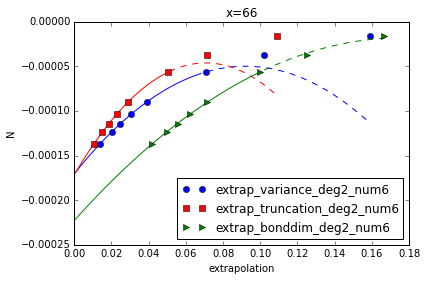

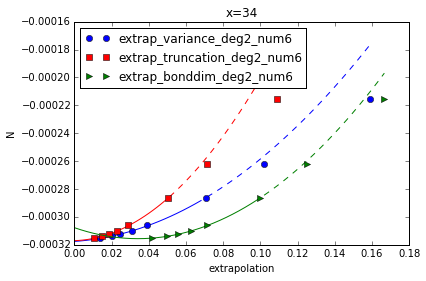

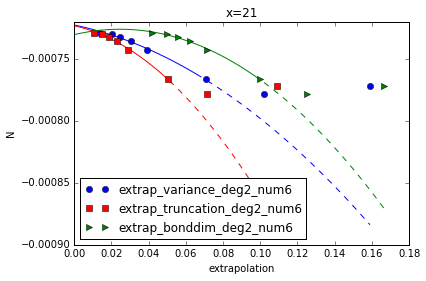

In [5]:
L = 128
filling = 0.875
corr_type = utils.Averaged()

all_extraps = []
all_extraps.append((1., utils.Extrapolation('variance', deg=2, num_points=6)))
all_extraps.append((1e4, utils.Extrapolation('truncation', deg=2, num_points=6)))
all_extraps.append((200, utils.Extrapolation('bonddim', deg=2, num_points=6)))

markers = 'os>v*'
colors  = 'brgk' 

for at_x in [66,34,21]:
    figure()
    for i,(scale_factor,bond_dim) in enumerate(all_extraps):
        d, props = load.extrapolation('densdens', L=L, filling=filling, bond_dim=bond_dim, at_x=at_x, correlation_type=corr_type)

        fit_coeff = props['fitted_coeff']
        xfit = linspace(0,max(d[:,0]))
        yfit = polyval(fit_coeff, xfit)
        
        sel = np.ones(len(xfit), dtype=bool)
        if 'fit_cut' in props:
            fit_cut = float(props['fit_cut'])
            sel = xfit <= fit_cut        
        plot(scale_factor*xfit[sel], yfit[sel], '-', color=colors[i])
        plot(scale_factor*xfit[-sel], yfit[-sel], '--', color=colors[i])
        
        plot(scale_factor*d[:,0], d[:,1], markers[i], color=colors[i], label=str(bond_dim))
    legend(loc='best')
    title('x={}'.format(at_x))
    xlabel('extrapolation')
    ylabel('N')

## Fig. 8, 10 : Results with reference decay

## FIT `fit_func` ##
# L      : 32.0
# fill   : 0.875
# nholes : 4.0
K_rho : 1.22718496836
-- n0 : 1.73197725941
-- A : 0.234147300397
-- alpha : 0.613592484182
## FIT `fit_func` ##
# L      : 48.0
# fill   : 0.875
# nholes : 6.0
K_rho : 0.947914220961
-- n0 : 1.73700008063
-- A : 0.155143954703
-- alpha : 0.473957110481
# Discard L=64, n=0.875, tperp=1.0, M=1200 : middle density not symmetry, delta=6.06578743847e-05
## FIT `fit_func` ##
# L      : 64.0
# fill   : 0.875
# nholes : 8.0
K_rho : 1.05040831464
-- n0 : 1.74052419043
-- A : 0.184392511003
-- alpha : 0.525204157322
# Discard L=80, n=0.875, tperp=1.0, M=1600 : middle density not symmetry, delta=7.58018820748e-05
## FIT `fit_func` ##
# L      : 80.0
# fill   : 0.875
# nholes : 10.0
K_rho : 1.09498021525
-- n0 : 1.74199497102
-- A : 0.200577946778
-- alpha : 0.547490107626
# Discard L=96, n=0.875, tperp=1.0, M=1200 : middle density not symmetry, delta=5.41602952064e-05
## FIT `fit_func` ##
# L      : 96.0
# fill   : 0.875
# nhol

scripts/pyalps_dset/fit_wrapper.py:34: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if x == None: x = np.arange(y.shape[0])
scripts/density.py:139: RuntimeWarning: invalid value encountered in power
  return A * np.cos(2*np.pi*kk*x + shift) / ((2*L_eff/np.pi) * np.sin(np.pi*x/L_eff + shift2))**alpha + n0


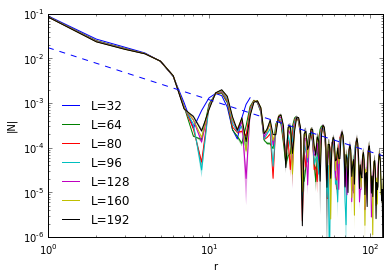

In [6]:
filling = 0.875
corr_type = utils.Averaged()

system_sizes = []
system_sizes.append(32)
system_sizes.append(64)
system_sizes.append(80)
system_sizes.append(96)
system_sizes.append(128)
system_sizes.append(160)
system_sizes.append(192)

figure()
## Plot correlations
for L in system_sizes:
    d, props = load_many_extrap('densdens', L=L, filling=filling, correlation_type=corr_type)
    line, = plot(d[:,0], abs(d[:,1]), label='L='+str(L))
    fill_between(d[:,0], abs(d[:,2]), abs(d[:,3]), edgecolor='none', facecolor=line.get_color(), alpha=.4)

## Reference decay
class power_law:
    def __init__(self, p, exponent):
        self.exponent = float(exponent)
        self.factor   = p[1] * p[0]**(-self.exponent)
    
    def __call__(self, x):
        return self.factor * x**self.exponent

xdecay = np.linspace(1,200)
p = (18, 0.0006)
Krho = load.krho(filling=filling, bond_dim=bond_dim)
ydecay = power_law(p, -Krho)(xdecay)
plot(xdecay, ydecay, '--')

## Plot settings
xlim(1, 120)
ylim(1e-6, 1e-1)
legend(loc='best', frameon=False)
xscale('log')
yscale('log')
xlabel('r')
ylabel('|N|')

## FIT `fit_func` ##
# L      : 32.0
# fill   : 0.9375
# nholes : 2.0
K_rho : -2.07704625778
-- n0 : 1.837844537
-- A : 0.00277158780668
-- alpha : -1.03852312889
## FIT `fit_func` ##
# L      : 48.0
# fill   : 0.916666666667
# nholes : 3.0
K_rho : -2.28948953578
-- n0 : 1.86271370437
-- A : -0.000891264574556
-- alpha : -1.14474476789
## FIT `fit_func` ##
# L      : 64.0
# fill   : 0.9375
# nholes : 4.0
K_rho : 0.921179505132
-- n0 : 1.86369364261
-- A : 0.16738527464
-- alpha : 0.460589752566
# Discard L=80, n=0.925, tperp=1.0, M=1200 : middle density not symmetry, delta=5.68333242994e-05
## FIT `fit_func` ##
# L      : 80.0
# fill   : 0.925
# nholes : 5.0
K_rho : -0.987740911604
-- n0 : 1.86417665713
-- A : -0.00402846772517
-- alpha : -0.493870455802
## FIT `fit_func` ##
# L      : 96.0
# fill   : 0.9375
# nholes : 6.0
K_rho : 1.17055405725
-- n0 : 1.86478292415
-- A : 0.24992373255
-- alpha : 0.585277028627
# Discard L=128, n=0.9375, tperp=1.0, M=1200 : middle density not symmetry

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/optimize/minpack.py:421: RuntimeWarning: Number of calls to function has reached maxfev = 800.
  warnings.warn(errors[info][0], RuntimeWarning)


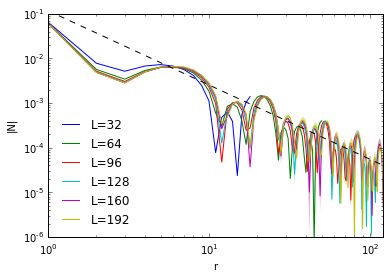

In [7]:
filling = 0.9375
corr_type = utils.Averaged()

system_sizes = []
system_sizes.append(32)
system_sizes.append(64)
system_sizes.append(96)
system_sizes.append(128)
system_sizes.append(160)
system_sizes.append(192)

figure()
## Plot correlations
for L in system_sizes:
    d, props = load_many_extrap('densdens', L=L, filling=filling, correlation_type=corr_type)
    line, = plot(d[:,0], abs(d[:,1]), label='L='+str(L))
    fill_between(d[:,0], abs(d[:,2]), abs(d[:,3]), edgecolor='none', facecolor=line.get_color(), alpha=.4)

## Reference decay
class power_law:
    def __init__(self, p, exponent):
        self.exponent = float(exponent)
        self.factor   = p[1] * p[0]**(-self.exponent)
    
    def __call__(self, x):
        return self.factor * x**self.exponent

xdecay = np.linspace(1,200)
p=(20, 0.0008)

Krho = load.krho(filling=filling, bond_dim=bond_dim)
ydecay = power_law(p, -Krho)(xdecay)
plot(xdecay, ydecay, '--')

## Plot settings
xlim(1, 120)
ylim(1e-6, 1e-1)
legend(loc='best', frameon=False)
xscale('log')
yscale('log')
xlabel('r')
ylabel('|N|')

## FIT `fit_func` ##
# L      : 32.0
# fill   : 0.9375
# nholes : 1.0
K_rho : -0.339834968177
-- n0 : 1.93572282771
-- A : -0.0424279769931
-- alpha : -0.169917484088
Data not found for L=48, n=0.96875, M=extrap_bonddim_deg2_num6
## FIT `fit_func` ##
# L      : 64.0
# fill   : 0.96875
# nholes : 2.0
K_rho : -2.94740462669
-- n0 : 1.91504839476
-- A : 0.000141451015957
-- alpha : -1.47370231334
Data not found for L=80, n=0.96875, M=extrap_bonddim_deg2_num6
## FIT `fit_func` ##
# L      : 96.0
# fill   : 0.958333333333
# nholes : 3.0
K_rho : -2.86685143349
-- n0 : 1.9309514869
-- A : -5.79086728805e-05
-- alpha : -1.43342571675
# Discard L=128, n=0.96875, tperp=1.0, M=1200 : middle density not symmetry, delta=0.00129310249938
# Discard L=128, n=0.96875, tperp=1.0, M=1600 : middle density not symmetry, delta=0.000144364999007
# Discard L=128, n=0.96875, tperp=1.0, M=2000 : middle density not symmetry, delta=0.000576815380084
## FIT `fit_func` ##
# L      : 128.0
# fill   : 0.96875
# nhole

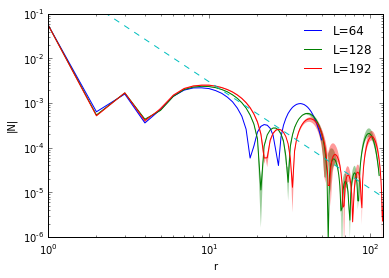

In [8]:
filling = 0.96875
corr_type = utils.Averaged()

system_sizes = []
system_sizes.append(64)
system_sizes.append(128)
system_sizes.append(192)

figure()
## Plot correlations
for L in system_sizes:
    d, props = load_many_extrap('densdens', L=L, filling=filling, correlation_type=corr_type)
    line, = plot(d[:,0], abs(d[:,1]), label='L='+str(L))
    fill_between(d[:,0], abs(d[:,2]), abs(d[:,3]), edgecolor='none', facecolor=line.get_color(), alpha=.4)

## Reference decay
class power_law:
    def __init__(self, p, exponent):
        self.exponent = float(exponent)
        self.factor   = p[1] * p[0]**(-self.exponent)
    
    def __call__(self, x):
        return self.factor * x**self.exponent

xdecay = np.linspace(1,200)
p=(10, 0.003)

Krho = load.krho(filling=filling, bond_dim=bond_dim, amplitude_points=2)
ydecay = power_law(p, -Krho)(xdecay)
plot(xdecay, ydecay, '--')

## Plot settings
xlim(1, 120)
ylim(1e-6, 1e-1)
legend(loc='best', frameon=False)
xscale('log')
yscale('log')
xlabel('r')
ylabel('|N|')